# Annotator modeling evaluation

__Objective:__ evaluate the performance of a trained SepHeads model,
- aggregated metrics (across annotators),
- metrics per annotator.

**Notes:**
- If the model has been trained on a subset of annotators, evaluation must be performed only on those annotators.

In [1]:
import os
import sys
from copy import deepcopy
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, EvalPrediction
import safetensors
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../modules/')

from model_utils import get_deberta_model
from data_utils import subsample_dataset
from models import DebertaWithAnnotatorHeads, DebertaWithAnnotatorHeadsPretrainedConfig, DebertaWithAnnotatorHeadsPretrained
from model_utils import load_sepheads_model_safetensors
from pytorch_utils import send_batch_to_device
from training_metrics import compute_metrics_sklearn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme()

%load_ext autoreload
%autoreload 2

In [3]:
# Paths to data.
# Note: the datasets must be exactly the ones used for model training!
TRAINING_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/sepheads_model_training_test_subsampling_2/training_data_subsampled.csv'
TEST_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/sepheads_model_training_test_subsampling_2/test_data_subsampled.csv'
ANNOTATORS_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/annotators_data.csv'

# Paths to the DeBERTa v2 pre-trained model (from Hugging Face) - in case the default
# directory for caching downloaded models is not used.
DEBERTA_MODEL_DIR = '/data1/shared_models/'

# Paths to the checkpoint of the fine-tuned model we want to load.
CHECKPOINT_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/sepheads_model_training_test_subsampling_2/checkpoint-42903/'

## Load data and fine-tuned model

Load data.

In [4]:
training_data = pd.read_csv(TRAINING_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

annotator_ids = sorted(set(training_data['annotator_id']))

In [16]:
# # For good measure, let's save the subsampled datasets.
# training_data.drop(columns=['extreme_annotator']).to_csv('/data1/moscato/personalised-hate-boundaries-data/models/sepheads_model_training_test_subsampling_2/training_data_subsampled.csv', index=None)
# test_data.drop(columns=['extreme_annotator']).to_csv('/data1/moscato/personalised-hate-boundaries-data/models/sepheads_model_training_test_subsampling_2/test_data_subsampled.csv', index=None)

**Note:** if loading the model as a `DebertaWithAnnotatorHeadsPretrained` object (see the `use_pretrained_object` option below), in case the training did not save a config object (e.g. if a `DebertaWithAnnotatorHeads` was used instead of a `DebertaWithAnnotatorHeadsPretrained`), then the config must be created and placed in the checkpoint's directory. If we do this, we need to make sure that the annoatator IDs are the same as the ones we used for training (i.e. that the data above was loaded exactly as during training).

In [6]:
# config = DebertaWithAnnotatorHeadsPretrainedConfig(
#     num_labels=2,
#     annotator_ids=annotator_ids,
#     deberta_model_dir=DEBERTA_MODEL_DIR
# )

# config.save_pretrained(CHECKPOINT_PATH)

# config = DebertaWithAnnotatorHeadsPretrainedConfig.from_pretrained(MODEL_DIR)

In [7]:
# # Instantiate new model from config.
# deberta_with_annotator_heads_pretrained_model = DebertaWithAnnotatorHeadsPretrained(config)

# deberta_with_annotator_heads_pretrained_model

Load tokenizer and fine-tuned model.

In [5]:
tokenizer, _ = get_deberta_model(
    num_labels=2,
    device=device,
    model_dir=DEBERTA_MODEL_DIR,
    use_custom_head=False
)

use_pretrained_object = True

if use_pretrained_object:
    model = DebertaWithAnnotatorHeadsPretrained.from_pretrained(CHECKPOINT_PATH).to(device=device)
else:
    model = load_sepheads_model_safetensors(
        checkpoint_path=CHECKPOINT_PATH,
        annotator_ids=annotator_ids,
        deberta_model_dir=DEBERTA_MODEL_DIR,
        device=device
    )

model.eval();

2025-03-12 11:45:06,514 - get_deberta_model - INFO - Instantiating DeBERTa tokenizer
2025-03-12 11:45:07,023 - get_deberta_model - INFO - Instantiating DeBERTa model with default classification head
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Get predictions

Get predictions on the test set.

In [21]:
test_batch_size = 16

predicted_logits = []

# Loop over test batches and accumulate the predictions.
for test_batch in tqdm(np.array_split(test_data, np.ceil(len(test_data) / test_batch_size))):
    with torch.no_grad():
        predicted_logits_batch = model(**send_batch_to_device(
            dict(
                **tokenizer(
                    test_batch['comment'].tolist(),
                    padding='max_length',
                    truncation=True,
                    max_length=512,
                    return_tensors='pt'
                ),
                **{'annotator_ids': torch.LongTensor(test_batch['annotator_id'].values).to(device=device)}
            ),
            device,
            return_batch=True
        ))['logits']

    predicted_logits.append(predicted_logits_batch)

predicted_logits = torch.cat(predicted_logits).cpu().numpy()
predicted_toxic_score = np.argmax(predicted_logits, axis=-1)

/home/moscato/miniconda3/envs/phb/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/2216 [00:00<?, ?it/s]

Save predictions to disk if needed.

In [46]:
test_data.shape

(35447, 6)

In [8]:
PREDICTED_LOGITS_OUTPUT_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/sepheads_model_training_test_subsampling_2/checkpoint-42903/predicted_logits_test.npy'
PREDICTED_TOXIC_SCORE_OUTPUT_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/sepheads_model_training_test_subsampling_2/checkpoint-42903/predicted_toxic_score_test.npy'

# np.save(
#     PREDICTED_LOGITS_OUTPUT_PATH,
#     predicted_logits
# )

# np.save(
#     PREDICTED_TOXIC_SCORE_OUTPUT_PATH,
#     predicted_toxic_score
# )

## Analysis

Load predictions.

In [9]:
predicted_logits = np.load(PREDICTED_LOGITS_OUTPUT_PATH)
predicted_toxic_score = np.load(PREDICTED_TOXIC_SCORE_OUTPUT_PATH)

test_data['predicted_toxic_score'] = predicted_toxic_score

### Global metrics

In [10]:
eval_pred = EvalPrediction(
    predictions=predicted_logits,
    label_ids=test_data['toxic_score'].values
)

eval_metrics = compute_metrics_sklearn(eval_pred)

eval_metrics

{'accuracy': 0.7492594577820408,
 'f1': np.float64(0.7463303763935492),
 'precision': np.float64(0.7455768337846722),
 'recall': np.float64(0.747665175504056)}

### Annotator-specific metrics

In [11]:
for i in range(predicted_logits.shape[-1]):
    test_data[f'predicted_logit_{i}'] = predicted_logits[:, i]

In [12]:
annotator_metrics = test_data.groupby('annotator_id').apply(
    lambda g: compute_metrics_sklearn(
        EvalPrediction(
            predictions=g[['predicted_logit_0', 'predicted_logit_1']].values,
            label_ids=g['toxic_score'].values
        )
    )
).reset_index().rename(columns={0: 'metrics'})

annotator_metrics = pd.DataFrame([
    {
        'annotator_id': row['annotator_id'],
        'accuracy': row['metrics']['accuracy'],
        'recall': row['metrics']['recall'],
        'precision': row['metrics']['precision'],
        'f1': row['metrics']['f1']
        
    }
    for i, row in annotator_metrics.iterrows()
])

annotator_metrics = pd.merge(
    left=annotator_metrics,
    right=pd.merge(
        left=training_data.groupby('annotator_id')['text_id'].count().reset_index().rename(columns={'text_id': 'n_training_samples'}),
        right=test_data.groupby('annotator_id')['text_id'].count().reset_index().rename(columns={'text_id': 'n_test_samples'}),
        on='annotator_id',
        how='inner'
    ),
    on='annotator_id',
    how='inner'
)

annotators_data = pd.read_csv(ANNOTATORS_DATA_PATH)

annotator_metrics = pd.merge(
    left=annotator_metrics,
    right=annotators_data[['annotator_id', 'extreme_annotator']],
    on='annotator_id',
    how='left'
)

annotator_metrics

/tmp/ipykernel_954557/526235234.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annotator_metrics = test_data.groupby('annotator_id').apply(


,annotator_id,accuracy,recall,precision,f1,n_training_samples,n_test_samples,extreme_annotator
0,1,0.750000,0.650000,0.611111,0.621053,48,12,False
1,2,0.700000,0.666667,0.637363,0.642857,80,20,False
2,3,0.764706,0.777778,0.833333,0.757143,43,17,False
3,14,0.900000,0.916667,0.900000,0.898990,50,10,False
4,15,0.388889,0.500000,0.388889,0.280000,62,18,False
...,...,...,...,...,...,...,...,...
2878,16935,1.000000,1.000000,1.000000,1.000000,16,4,True
2879,16974,0.666667,0.500000,0.666667,0.400000,17,3,True
2880,16992,0.833333,0.500000,0.833333,0.454545,14,6,True
2881,17056,1.000000,1.000000,1.000000,1.000000,16,4,True


Metrics VS number of samples.

Quartiles (N training samples): [42. 49. 63.]
Quartiles (N test samples): [ 7. 12. 16.]


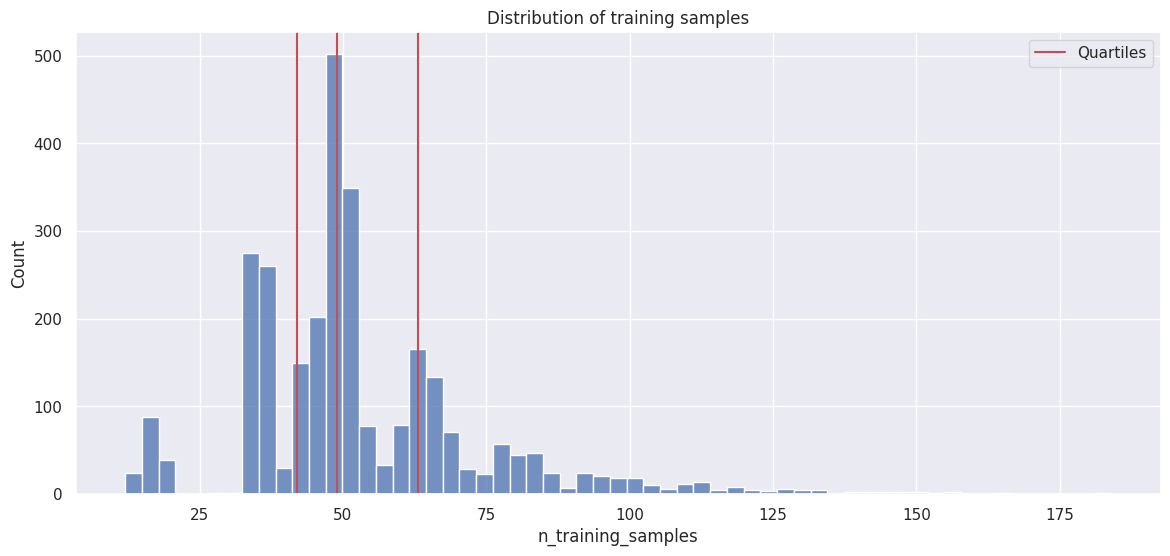

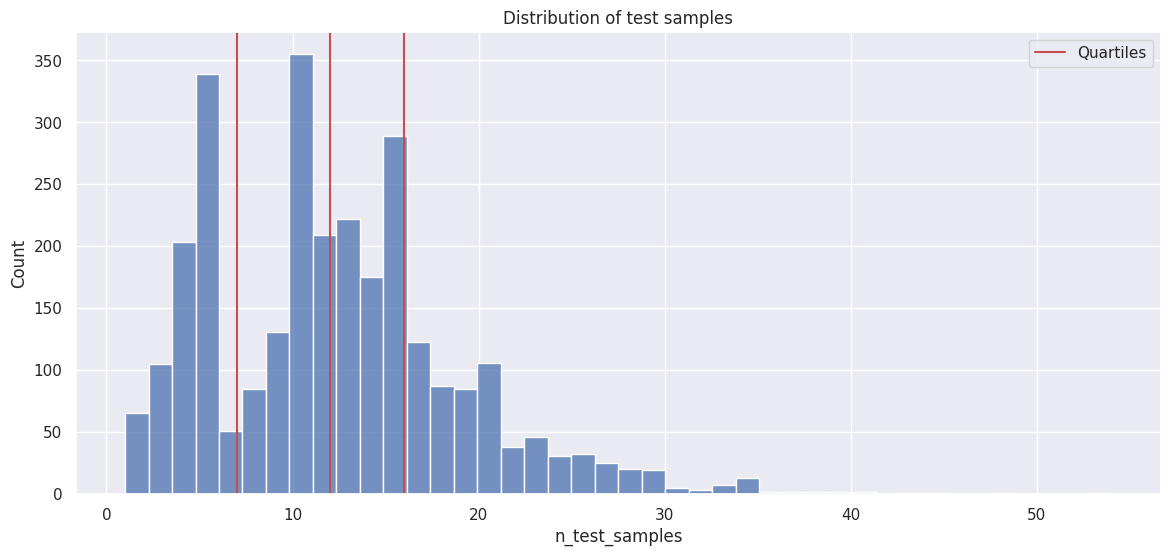

In [13]:
# Distribution of training samples.
fig = plt.figure(figsize=(14, 6))

sns.histplot(
    x=annotator_metrics['n_training_samples']
)

for i, quartile in enumerate(annotator_metrics['n_training_samples'].quantile([.25, .5, .75])):
    plt.axvline(
        x=quartile,
        label='Quartiles' if i == 0 else None,
        color='r'
    )

plt.legend()
plt.title('Distribution of training samples')

print('Quartiles (N training samples):', annotator_metrics['n_training_samples'].quantile([.25, .5, .75]).values)


# Distribution of test samples.
fig = plt.figure(figsize=(14, 6))

sns.histplot(
    x=annotator_metrics['n_test_samples']
)

for i, quartile in enumerate(annotator_metrics['n_test_samples'].quantile([.25, .5, .75])):
    plt.axvline(
        x=quartile,
        label='Quartiles' if i == 0 else None,
        color='r'
    )

plt.legend()
plt.title('Distribution of test samples')

print('Quartiles (N test samples):', annotator_metrics['n_test_samples'].quantile([.25, .5, .75]).values)

In [17]:
annotator_metrics

,annotator_id,accuracy,recall,precision,f1,n_training_samples,n_test_samples,extreme_annotator
0,1,0.750000,0.650000,0.611111,0.621053,48,12,False
1,2,0.700000,0.666667,0.637363,0.642857,80,20,False
2,3,0.764706,0.777778,0.833333,0.757143,43,17,False
3,14,0.900000,0.916667,0.900000,0.898990,50,10,False
4,15,0.388889,0.500000,0.388889,0.280000,62,18,False
...,...,...,...,...,...,...,...,...
2878,16935,1.000000,1.000000,1.000000,1.000000,16,4,True
2879,16974,0.666667,0.500000,0.666667,0.400000,17,3,True
2880,16992,0.833333,0.500000,0.833333,0.454545,14,6,True
2881,17056,1.000000,1.000000,1.000000,1.000000,16,4,True


Text(0.5, 1.0, 'Metrics VS N test samples')

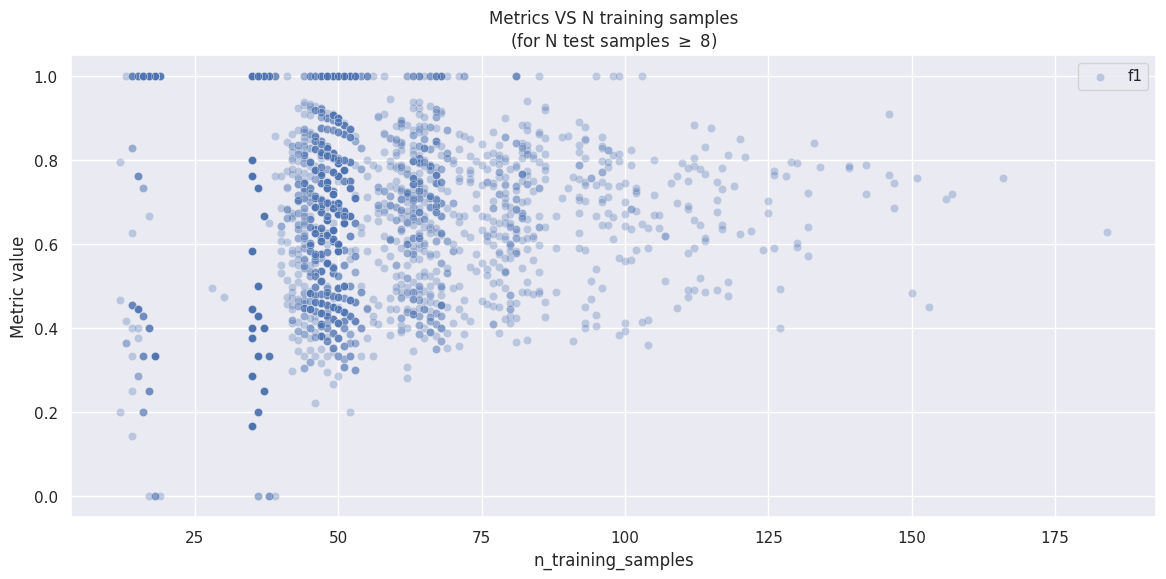

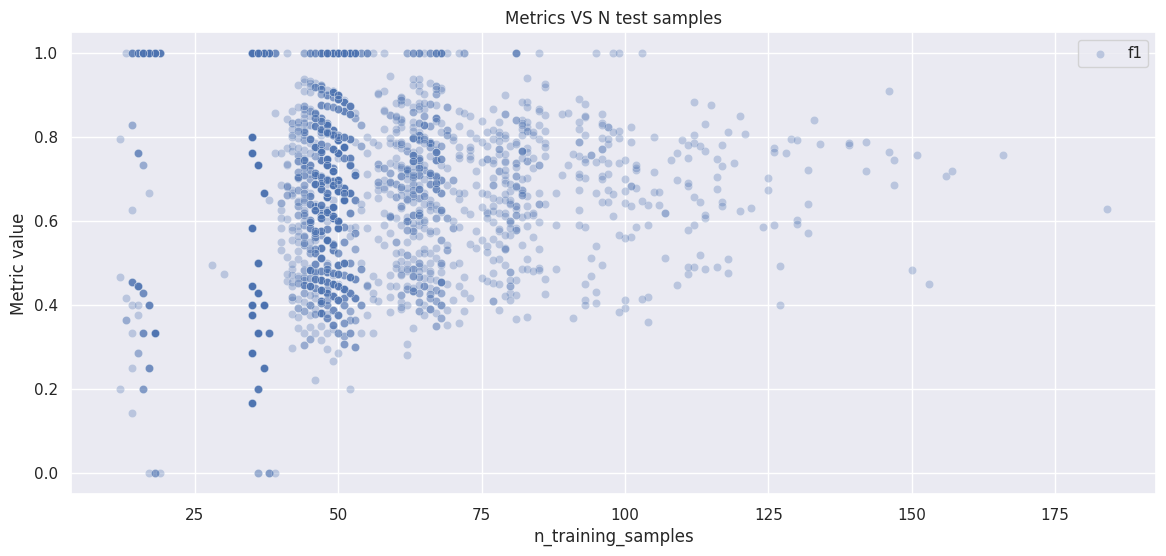

In [26]:
# Metrics VS N training samples.
fig = plt.figure(figsize=(14, 6))

min_test_samples = 8

for metric in ['accuracy', 'recall', 'precision', 'f1'][-1:]:
    # Lineplot version.
    # sns.lineplot(
    #     x=annotator_metrics['n_training_samples'],
    #     y=annotator_metrics[metric],
    #     label=metric
    # )

    # Scatterplot version.
    sns.scatterplot(
        x=annotator_metrics['n_training_samples'],
        y=annotator_metrics[metric],
        label=metric,
        alpha=.3
    )

plt.legend()
plt.ylabel('Metric value')
plt.title(f'Metrics VS N training samples\n(for N test samples $\geq$ {min_test_samples})')


# Metrics VS N test samples.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'recall', 'precision', 'f1'][-1:]:
    metric_vs_training_samples = annotator_metrics.groupby('n_test_samples')[metric].mean().reset_index()

    # Lineplot version.
    # sns.lineplot(
    #     x=annotator_metrics['n_test_samples'],
    #     y=annotator_metrics[metric],
    #     label=metric
    # )

    # Scatterplot version.
    sns.scatterplot(
        x=annotator_metrics['n_training_samples'],
        y=annotator_metrics[metric],
        label=metric,
        alpha=.3
    )

plt.legend()
plt.ylabel('Metric value')
plt.title('Metrics VS N test samples')

Text(0.5, 1.0, 'Metrics VS N test samples')

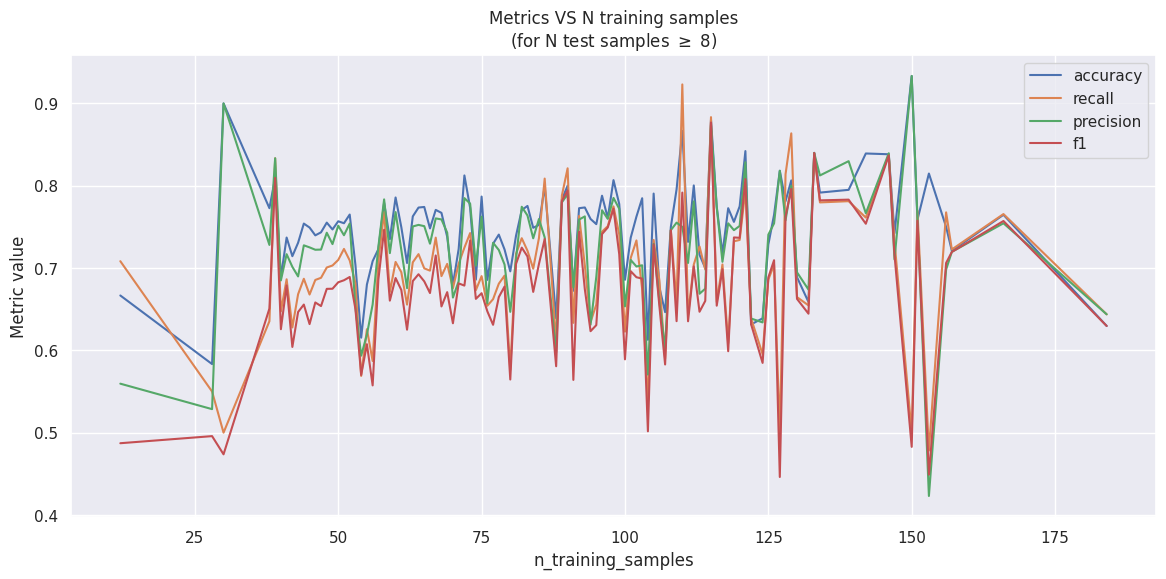

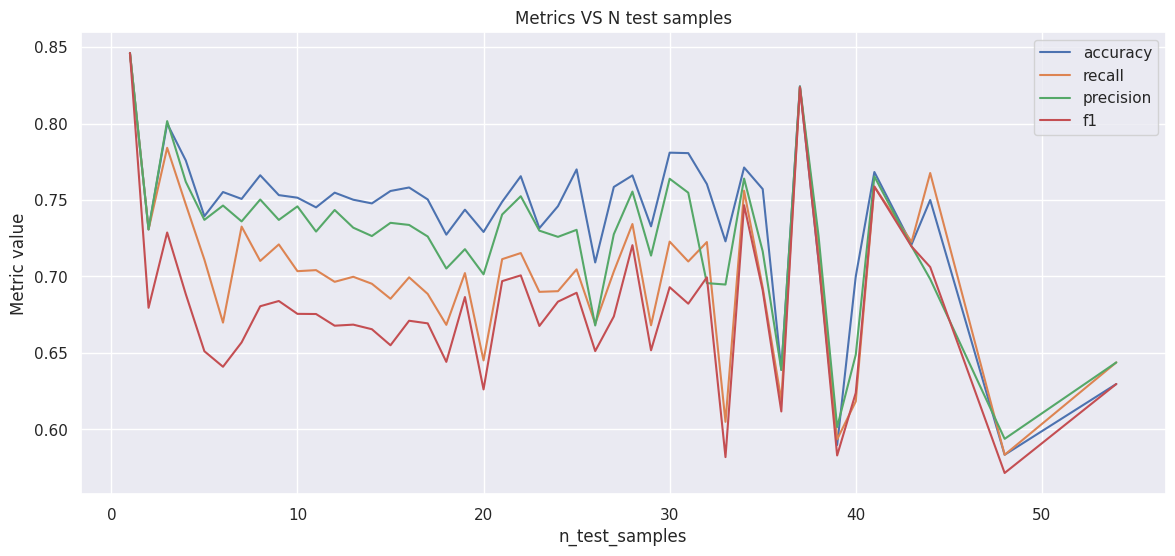

In [27]:
# Metrics VS N training samples.
fig = plt.figure(figsize=(14, 6))

min_test_samples = 8

for metric in ['accuracy', 'recall', 'precision', 'f1']:
    metric_vs_training_samples = annotator_metrics[
        annotator_metrics['n_test_samples'] >= min_test_samples
    ].groupby('n_training_samples')[metric].mean().reset_index()

    sns.lineplot(
        x=metric_vs_training_samples['n_training_samples'],
        y=metric_vs_training_samples[metric],
        label=metric
    )

plt.legend()
plt.ylabel('Metric value')
plt.title(f'Metrics VS N training samples\n(for N test samples $\geq$ {min_test_samples})')

# Metrics VS N test samples.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'recall', 'precision', 'f1']:
    metric_vs_training_samples = annotator_metrics.groupby('n_test_samples')[metric].mean().reset_index()

    sns.lineplot(
        x=metric_vs_training_samples['n_test_samples'],
        y=metric_vs_training_samples[metric],
        label=metric
    )

plt.legend()
plt.ylabel('Metric value')
plt.title('Metrics VS N test samples')

Metrics VS extreme annotators.

In [28]:
annotator_metrics.groupby('extreme_annotator').agg(
    accuracy_mean=pd.NamedAgg('accuracy', 'mean'),
    accuracy_std=pd.NamedAgg('accuracy', 'std'),
    precision_mean=pd.NamedAgg('precision', 'mean'),
    precision_std=pd.NamedAgg('precision', 'std'),
    recall_mean=pd.NamedAgg('recall', 'mean'),
    recall_std=pd.NamedAgg('recall', 'std'),
    f1_mean=pd.NamedAgg('f1', 'mean'),
    f1_std=pd.NamedAgg('f1', 'std'),
)

,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
extreme_annotator,,,,,,,,
False,0.749840,0.158743,0.734940,0.178588,0.703561,0.183171,0.67016,0.199855
True,0.799616,0.270971,0.789247,0.278002,0.770361,0.284575,0.71594,0.329518


In [29]:
annotator_metrics

,annotator_id,accuracy,recall,precision,f1,n_training_samples,n_test_samples,extreme_annotator
0,1,0.750000,0.650000,0.611111,0.621053,48,12,False
1,2,0.700000,0.666667,0.637363,0.642857,80,20,False
2,3,0.764706,0.777778,0.833333,0.757143,43,17,False
3,14,0.900000,0.916667,0.900000,0.898990,50,10,False
4,15,0.388889,0.500000,0.388889,0.280000,62,18,False
...,...,...,...,...,...,...,...,...
2878,16935,1.000000,1.000000,1.000000,1.000000,16,4,True
2879,16974,0.666667,0.500000,0.666667,0.400000,17,3,True
2880,16992,0.833333,0.500000,0.833333,0.454545,14,6,True
2881,17056,1.000000,1.000000,1.000000,1.000000,16,4,True


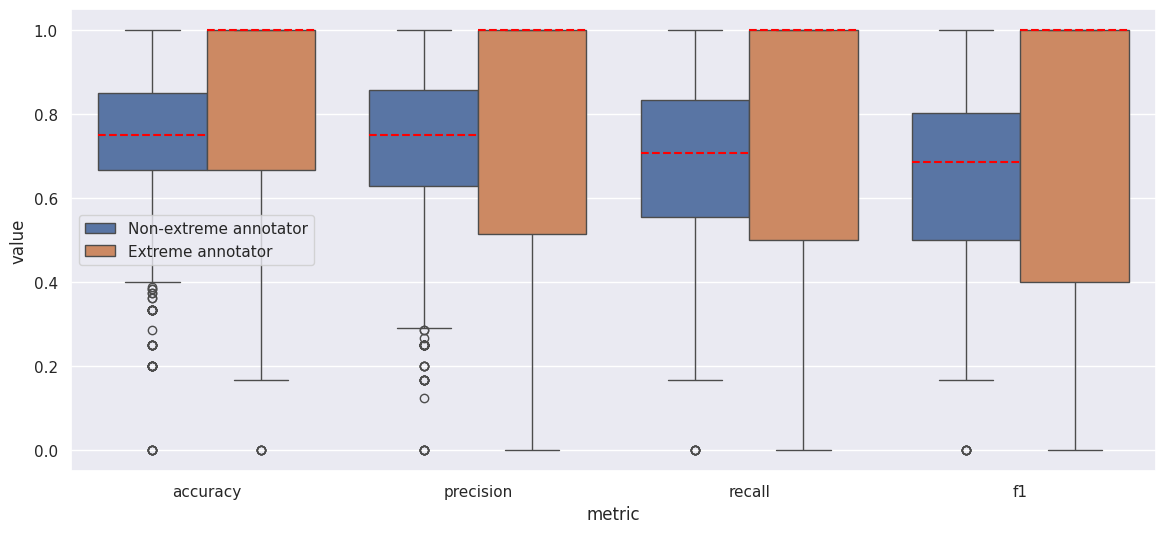

In [41]:
boxplot_data = []

for metric in ['accuracy', 'precision', 'recall', 'f1']:
    metric_data = annotator_metrics[['extreme_annotator', metric]].rename(columns={metric: 'value'})
    metric_data['metric'] = metric
    metric_data['extreme_annotator'] = metric_data['extreme_annotator'].apply(
        lambda x: 'Extreme annotator' if x else 'Non-extreme annotator'
    )

    boxplot_data.append(metric_data)

boxplot_data = pd.concat(boxplot_data).reset_index(drop=True)


fig = plt.figure(figsize=(14, 6))

sns.boxplot(
    data=boxplot_data,
    x="metric",
    y="value",
    hue="extreme_annotator",
    medianprops={'color': 'red', 'ls': '--', 'lw': 1.5}
)

plt.legend()

**Check:** how often does the model predict toxicity score 0 with extreme annotator heads - i.e. does the model collapse on a trivial classifier for extreme annotators?

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [65]:
test_data_extreme_annotators = pd.merge(
    left=test_data,
    right=annotators_data[['annotator_id', 'extreme_annotator']],
    on='annotator_id',
    how='left'
).query('extreme_annotator == True').reset_index(drop=True)

test_data_extreme_annotators

,comment,text_id,worker_id,toxic_score,annotator_id,predicted_toxic_score,predicted_logit_0,predicted_logit_1,extreme_annotator
0,I never really thought Jew shilling was real u...,2434,a8990a5b299fad8ba6c893473fe6d08e98438c3f218b5f...,1,603,0,0.369955,-0.032329,True
1,Fool why is Twitter so sad tonight 🤣,2440,a8990a5b299fad8ba6c893473fe6d08e98438c3f218b5f...,0,603,0,1.066759,-3.088866,True
2,I—- Thot Culture is a real epidemic y’all.,2443,a8990a5b299fad8ba6c893473fe6d08e98438c3f218b5f...,0,603,0,1.681815,-1.376208,True
3,😭😭😭😂😂😂😂wheeeeeet?! NEVER!!! hot girl mode stil...,2444,a8990a5b299fad8ba6c893473fe6d08e98438c3f218b5f...,0,603,0,1.574879,-1.725831,True
4,What the fuck is this shit,2446,a8990a5b299fad8ba6c893473fe6d08e98438c3f218b5f...,0,603,0,0.436850,-0.082086,True
...,...,...,...,...,...,...,...,...,...
597,"My grandfather who I never met, apparently far...",105693,029fb530823923d9287d93f312b91fc7ce697da1d8ad6e...,0,17058,0,1.887576,-1.319970,True
598,9.Spamming images of Muslims with knives and w...,9981,029fb530823923d9287d93f312b91fc7ce697da1d8ad6e...,0,17058,0,1.272291,-0.961975,True
599,Jesus had the power to lay down His life,105702,029fb530823923d9287d93f312b91fc7ce697da1d8ad6e...,0,17058,0,2.228225,-1.223986,True
600,women never realize that they are the damn pro...,105703,029fb530823923d9287d93f312b91fc7ce697da1d8ad6e...,1,17058,0,0.940629,-0.781796,True


(602, 2)

In [81]:
eval_pred = EvalPrediction(
    predictions=test_data_extreme_annotators[['predicted_logit_0', 'predicted_logit_1']].values,
    label_ids=test_data_extreme_annotators['toxic_score'].values
)

eval_metrics = compute_metrics_sklearn(eval_pred)

eval_metrics

{'accuracy': 0.7940199335548173,
 'f1': np.float64(0.6732385488163608),
 'precision': np.float64(0.6848726203546904),
 'recall': np.float64(0.6646829672606713)}

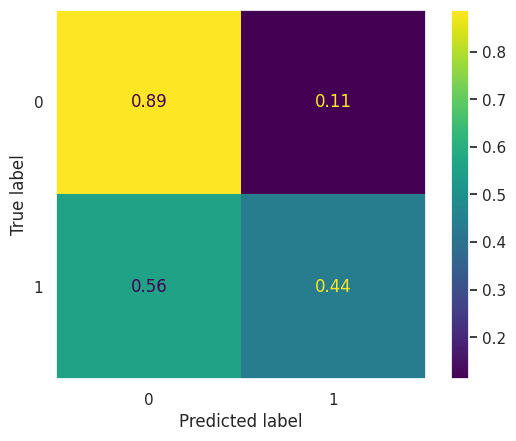

In [76]:
ConfusionMatrixDisplay(confusion_matrix(
    y_true=test_data_extreme_annotators['toxic_score'],
    y_pred=test_data_extreme_annotators['predicted_toxic_score'],
    normalize='true'
)).plot()

plt.grid(False)

In [82]:
extreme_annotator_prediction_counts = test_data_extreme_annotators.groupby('annotator_id').agg(
    n_test_samples=pd.NamedAgg('text_id', 'count'),
    n_preds_0=pd.NamedAgg('predicted_toxic_score', lambda s: (s == 0).sum()),
    n_preds_1=pd.NamedAgg('predicted_toxic_score', lambda s: (s == 1).sum()),
    n_gt_0=pd.NamedAgg('toxic_score', lambda s: (s == 0).sum()),
    n_gt_1=pd.NamedAgg('toxic_score', lambda s: (s == 1).sum()),
).reset_index()

extreme_annotator_prediction_counts

,annotator_id,n_test_samples,n_preds_0,n_preds_1,n_gt_0,n_gt_1
0,603,6,6,0,5,1
1,633,3,3,0,3,0
2,1856,15,15,0,15,0
3,2008,3,3,0,2,1
4,2980,5,4,1,5,0
...,...,...,...,...,...,...
150,16935,4,4,0,4,0
151,16974,3,3,0,2,1
152,16992,6,6,0,5,1
153,17056,4,3,1,3,1


In [86]:
# Fraction of extreme annotators for which the model predicts only label 0.
(extreme_annotator_prediction_counts['n_preds_1'] == 0).mean()

np.float64(0.6193548387096774)